<a href="https://colab.research.google.com/github/yogesh1000/PM-2.5-Forecast-For-kathmandu-valley/blob/main/multistep_3_days_multivarate(Dew_and_Tmin)_forecast_PM_2_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving ktm.csv to ktm.csv


In [ ]:
df = pd.read_csv('ktm.csv')

In [ ]:
df.head()

,Date,PM2.5,Tmax,Tmin,Humidity,Dew,Pressure,Wind Speed
0,12/31/2018,183,19.0,1.0,70.0,2.5,1023.0,1.5
1,1/1/2019,181,18.0,2.5,70.0,2.0,1023.0,1.5
2,1/2/2019,174,17.5,2.0,70.0,2.5,1023.0,1.5
3,1/3/2019,163,16.0,2.0,66.0,2.5,1022.0,1.8
4,1/4/2019,163,15.0,1.5,72.5,2.0,1022.5,1.5


In [ ]:
TRAIN_SPLIT = 457

In [ ]:
tf.random.set_seed(10)

In [ ]:
features_considered = ['PM2.5', 'Dew', 'Tmin']

In [ ]:
features = df[features_considered]
features.index = df['Date']
features.head()

,PM2.5,Dew,Tmin
Date,,,
12/31/2018,183,2.5,1.0
1/1/2019,181,2.0,2.5
1/2/2019,174,2.5,2.0
1/3/2019,163,2.5,2.0
1/4/2019,163,2.0,1.5


In [ ]:
dataset = features.values

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:

past_history = 20
future_target = 3
STEP = 1
BATCH_SIZE=20

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (20, 3)

 Target temperature to predict : (3,)


In [ ]:
print ('Single window of past history')
print (x_val_multi[0])
print ('\n Target temperature to predict')
print (y_val_multi[0])

Single window of past history
[[151.   14.   16. ]
 [ 78.   13.5  15. ]
 [ 99.   15.   16. ]
 [104.   16.5  17. ]
 [ 78.   13.5  14. ]
 [ 69.   12.   13. ]
 [ 74.   11.5  13. ]
 [ 46.   12.   13. ]
 [ 57.   12.   12. ]
 [ 76.   13.   12. ]
 [ 91.   13.5  13. ]
 [ 80.   15.   15. ]
 [ 85.   15.   14. ]
 [ 68.   15.   15. ]
 [ 67.   14.   14. ]
 [ 70.   15.   14. ]
 [ 65.   15.   14. ]
 [ 68.   16.   17. ]
 [ 67.   16.   16. ]
 [ 76.   16.   17. ]]

 Target temperature to predict
[62. 57. 42. 55. 65.]


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(30,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(15, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(3))
multi_step_model.add(tf.keras.layers.Lambda(lambda x:x*180))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(8, 3)


In [ ]:
EPOCHS=15
EVALUATION_INTERVAL=200
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/15
200/200 [==============================] - 13s 67ms/step - loss: 34.7418
Epoch 2/15
200/200 [==============================] - 14s 68ms/step - loss: 20.3156
Epoch 3/15
200/200 [==============================] - 14s 68ms/step - loss: 18.3987
Epoch 4/15
200/200 [==============================] - 13s 67ms/step - loss: 17.2933
Epoch 5/15
200/200 [==============================] - 14s 68ms/step - loss: 17.1604
Epoch 6/15
200/200 [==============================] - 13s 67ms/step - loss: 16.6398
Epoch 7/15
200/200 [==============================] - 14s 68ms/step - loss: 16.7531
Epoch 8/15
200/200 [==============================] - 13s 66ms/step - loss: 17.4190
Epoch 9/15
200/200 [==============================] - 14s 68ms/step - loss: 18.7851
Epoch 10/15
200/200 [==============================] - 14s 68ms/step - loss: 17.8959
Epoch 11/15
200/200 [==============================] - 13s 67ms/step - loss: 17.5020
Epoch 12/15
200/200 [==============================] - 13s 67ms/step - los

In [ ]:
sum=0
for i in range(8):
  for x, y in val_data_multi.take(1):
    test=multi_step_model.predict(x)[i].reshape(3,1)
    real=y[i].numpy().reshape(3,1)
  sum=sum+tf.keras.metrics.mean_absolute_error(real[:,0],test[:,0]).numpy()
sum/8  

21.0656681060791

In [ ]:

sum=0
for i in range(8):
  for x, y in val_data_multi.take(1):
    test=multi_step_model.predict(x)[i].reshape(3,1)
    real=y[i].numpy().reshape(3,1)
  sum=sum+(root_mean_squared_error(real[:,0],test[:,0]))
sum/8  

22.780417016487412

Text(0, 0.5, 'PM 2.5')

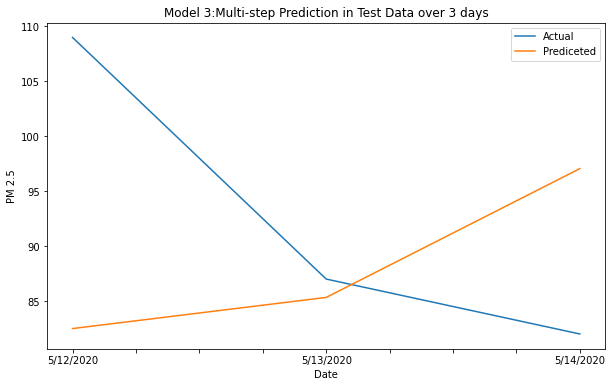

In [ ]:
time=np.array(df['Date'])
time_valid=time[-3:]

nseries=np.concatenate((real,test),axis=1)
dfs = pd.DataFrame(data=nseries, index=time_valid, columns=[ "Actual","Prediceted"])
dfs = pd.DataFrame(data=nseries, index=time_valid, columns=[ "Actual","Prediceted"])
ax=dfs.plot(figsize=(10,6),title='Model 3:Multi-step Prediction in Test Data over 3 days')
ax.set_xlabel("Date")
ax.set_ylabel("PM 2.5")

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  y_true=np.array(y_true)
  y_pred=np.array(y_pred)
  return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1))
print(root_mean_squared_error(real[:,0],test[:,0]))

24.330981226663678
